# EXAMPLES (RAG)
- [RAG](https://docs.activeloop.ai/examples/rag)
  - [RAG Quickstart](https://docs.activeloop.ai/examples/rag/quickstart)
  - [RAG Tutorials](https://docs.activeloop.ai/examples/rag/tutorials)
    - [Vector Store Basics](https://docs.activeloop.ai/examples/rag/tutorials/vector-store-basics)
    - [Vector Search Options](https://docs.activeloop.ai/examples/rag/tutorials/vector-search-options)
      - [LangChain API](https://docs.activeloop.ai/examples/rag/tutorials/vector-search-options/langchain-api)
      - [Deep Lake Vector Store API](https://docs.activeloop.ai/examples/rag/tutorials/vector-search-options/vector-store-api)
      - [Managed Database REST API](https://docs.activeloop.ai/examples/rag/tutorials/vector-search-options/rest-api)
    - [**Customizing Your Vector Store**](https://docs.activeloop.ai/examples/rag/tutorials/step-4-customizing-vector-stores)
    - [Image Similarity Search](https://docs.activeloop.ai/examples/rag/tutorials/image-similarity-search)
    - [Improving Search Accuracy using Deep Memory](https://docs.activeloop.ai/examples/rag/tutorials/deepmemory)


## RAG Tutorials (Customizing Your Vector Store)

### Customize Deep Lake Vector Stores for Images, Multi-Embedding Applications, and More
*Under-the-hood, Deep Lake vector stores use the Deep Lake tabular format, where Tensors are conceptually equivalent to columns. A unique feature in Deep Lake is that Tensors can be customized to a variety of use-cases beyond simple embeddings of text.*

#### Creating vector stores with non-text data
*To create a Vector Store for images, we should write a custom embedding function that embeds images from a file using a neural network, since we cannot use OpenAI for embedding images yet.*

In [1]:
import os
import torch
from torchvision import transforms, models
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
from IPython.display import display

from deeplake.core.vectorstore import VectorStore

C:\Users\Pavel\projects\ai-llm-deeplake\.venv\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (4.1.13) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
model = models.resnet18(pretrained=True)

return_nodes = {
    "avgpool": "embedding"
}
model = create_feature_extractor(model, return_nodes=return_nodes)

model.eval()
model.to("cpu")

C:\Users\Pavel\projects\ai-llm-deeplake\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Pavel\projects\ai-llm-deeplake\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Module(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [3]:
tform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], dim=0) if x.shape[0] == 1 else x),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

def embedding_function(images, model = model, transform = tform, batch_size = 4):
    """Creates a list of embeddings based on a list of image filenames. Images are processed in batches."""

    if isinstance(images, str):
        images = [images]

    # Proceess the embeddings in batches, but return everything as a single list
    embeddings = []
    for i in range(0, len(images), batch_size):
        batch = torch.stack([transform(Image.open(item)) for item in images[i:i+batch_size]])
        batch = batch.to("cpu")
        with torch.no_grad():
            embeddings+= model(batch)['embedding'][:,:,0,0].cpu().numpy().tolist()

    return embeddings

In [4]:
# Download and unzip 6 example images with common objects and create a list of containing their filenames
# - https://content.gitbook.com/content/WOs95B2h3lcO4dwXDRJ3/blobs/rYKE8GEhDANiu2iFGClB/common_objects.zip

# data_folder = '/Users/istranic/ActiveloopCode/Datasets/common_objects'
data_folder = './common_objects'

image_fns = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if os.path.splitext(file)[-1]=='.jpg']
image_fns

['./common_objects\\image_1.jpg',
 './common_objects\\image_2.jpg',
 './common_objects\\image_3.jpg',
 './common_objects\\image_4.jpg',
 './common_objects\\image_5.jpg',
 './common_objects\\image_6.jpg']

In [5]:
# Earlier in this tutorial, we did not specify any data-structure-related information when initializing the Vector Store,
#   which by default creates a vector store with tensors for text, metadata, id (auto-populated), and embedding.  

# Here, we create a Vector Store for image similarity search, which should contains tensors for the image,
#   its embedding, and the filename for the image. This can be achieved by specifying custom tensor_params.

# vector_store_path = "/vector_store_getting_started_images"
vector_store_path = "./vector_store_getting_started_images"

vector_store = VectorStore(
    path = vector_store_path,
    tensor_params = [{'name': 'image', 'htype': 'image', 'sample_compression': 'jpg'}, 
                     {'name': 'embedding', 'htype': 'embedding'}, 
                     {'name': 'filename', 'htype': 'text'}],
    overwrite = True  # This will DELETE all existing data
)

In [6]:
# Add data to the Vector Store just as if we were adding text data earlier in the Getting Started Guide

vector_store.add(image = image_fns,
                 filename = image_fns,
                 embedding_function = embedding_function, 
                 embedding_data = image_fns)

Creating 6 embeddings in 1 batches of size 6:: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]

Dataset(path='./vector_store_getting_started_images', tensors=['image', 'embedding', 'filename', 'id'])

  tensor      htype           shape           dtype  compression
  -------    -------         -------         -------  ------- 
   image      image    (6, 419:960, 640, 3)   uint8    jpeg   
 embedding  embedding        (6, 512)        float32   None   
 filename     text            (6, 1)           str     None   
    id        text            (6, 1)           str     None   


#### Performing image similarity search

In [7]:
# Find the image in the Vector Store that is most similar to the reference image below
# - https://content.gitbook.com/content/WOs95B2h3lcO4dwXDRJ3/blobs/urVFy2SyQlJmPBcXUutD/reference_image.jpg

# image_path = '/reference_image.jpg'
image_path = './reference_image.jpg'

result = vector_store.search(embedding_data = [image_path], embedding_function = embedding_function)

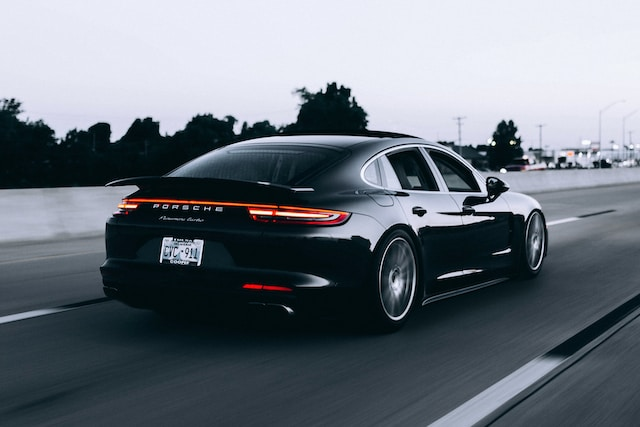

In [8]:
# Display the reference image

reference_image = Image.open(image_path)
display(reference_image)

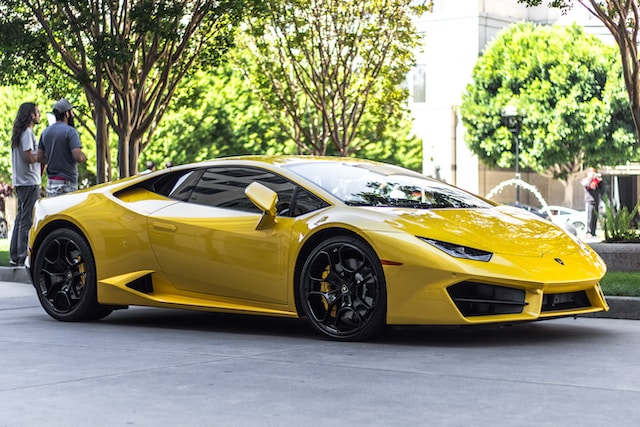

In [9]:
# Display the result of the most similar image, which shows a picture of a yellow Lamborghini,
#   which is fairly similar to the black Porsche above.

Image.fromarray(result['image'][0])

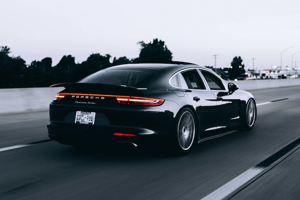

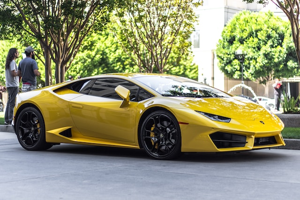

In [10]:
# Display image and modify its size

size=300,300

with Image.open(image_path) as i:
	i.thumbnail(size)
	display(i)
with Image.fromarray(result['image'][0]) as i:
	i.thumbnail(size)
	display(i)